## AIM: From a given email text, classify the texts as Signature or not.

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import optimizers
from keras.layers import Dense, LSTM
from keras.models import Sequential
from scipy.spatial import distance
import matplotlib.pyplot as plt
from spacy import displacy
import seaborn as sns
import pandas as pd
import numpy as np
import spacy
import regex
import keras
import re


In [3]:
list_line_number = []
list_line = []
list_per = []
list_org = []
list_loc = []
list_email = []
list_position_line = []
list_tel = []
list_line_index = []
list_expected_sign = []

In [4]:
email = pd.read_csv("annotated_ds.csv")

## Data Preprocessing

In [10]:
iter_temp = 0

for index in range(email.shape[0]):
    message = email.iloc[index]['message']
    text = message.split('X-FileName: ')[1].lstrip('\n')
    text = text[text.find('\n'):]
    
    iter_temp += 1
    
    line_index = 0
    lines = text.split('\n')
    
    counter_sign=0
    
    for line in lines:
 
        line = line.strip(" ")        
        if len(line) == 0:
            continue

        list_line_number.append(line_index)
        line_index += 1
        list_line.append(line)
        
        #print(line)
        
        if '(NAME)' in line:
            list_per.append(1)
        else:
            list_per.append(0)
            
        if '(EMAIL)' in line:
            list_email.append(1)
        else:
            list_email.append(0)
            
        if '(PHONE)' in line:
            list_tel.append(1)
        else:
            list_tel.append(0)
            
        if '(ORG)' in line:
            list_org.append(1)
        else:
            list_org.append(0)
            
        if '(NAME)' in line and counter_sign==0:
            counter_sign+=1
        elif '(NAME)' in line and counter_sign==1:
            list_expected_sign.append(0)
            counter_sign=1
        elif '(NAME)' in line and counter_sign>1:
            while counter_sign>0:
                list_expected_sign.append(1)
                counter_sign-=1
            counter_sign=1
        elif ('(ORG)' in line or '(PHONE)' in line or '(EMAIL)' in line) and counter_sign!=0:
            counter_sign+=1
        elif counter_sign>=2:
            while counter_sign>0:
                list_expected_sign.append(1)
                counter_sign-=1
            list_expected_sign.append(0)
        else:
            if counter_sign>0:
                list_expected_sign.append(0)
                list_expected_sign.append(0)
            else:
                list_expected_sign.append(0)
            counter_sign=0
            
        
        list_position_line.append(line_index)

            
    list_line_index.append(line_index)
        
    if counter_sign>=2:
        while counter_sign>0:
            list_expected_sign.append(1)
            counter_sign-=1
    if counter_sign>=1:
        list_expected_sign.append(0)
        
    #print(counter_sign)
    #print(list_expected_sign)
    #break
            



In [11]:
ann = [0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,
       0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,1,
       1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,
       0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
       0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,
       0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
       0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,
       0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1]

## Feature Extraction

In [12]:
df = pd.DataFrame(list(zip(list_line_number, list_line,list_per, list_org, list_tel, list_email, list_position_line, list_expected_sign, ann)),
                  columns =['line_number', 'line','PER', 'ORG', 'TEL', 'Email','position_line' , 'is_expected_sign','is_sign'])

first_i = 0
sum_index = 0
for index in range(len(list_line_index)):
    if first_i==0:
        df.loc[0:list_line_index[index],'position_line'] = df.loc[0:list_line_index[index],'position_line']/list_line_index[index]
        first_i=1
    else:
        df.loc[sum_index:sum_index + list_line_index[index]-1,'position_line'] = df.loc[sum_index:sum_index+list_line_index[index]-1,'position_line']/list_line_index[index]
    sum_index = sum_index + list_line_index[index]
        
df

line_number                                               line  PER  ORG  \
0              0                               Here is our forecast    0    0   
1              1                                             (NAME)    1    0   
2              2                                            (EMAIL)    0    0   
3              3                                            (PHONE)    0    0   
4              0  Traveling to have a business meeting takes the...    0    0   
..           ...                                                ...  ...  ...   
408           12                                         Thank you!    0    0   
409           13                                           Regards,    0    0   
410           14                                             (NAME)    1    0   
411           15                                              (ORG)    0    1   
412           16                                            (PHONE)    0    0   

     TEL  Email  position_line  is_expected_sign  is_sign  
0      0      0       0.250000                 0        0  
1      0      0       0.500000                 1        1  
2      0      1       0.750000                 1        1  
3      1      0       1.000000                 1        1  
4      0      0       0.041667                 0        0  
..   ...    ...            ...               ...      ...  
408    0      0       0.764706                 0        0  
409    0      0       0.823529                 0        0  
410    0      0       0.882353                 1        1  
411    0      0       0.941176                 1        1  
412    1      0       1.000000                 1        1  

[413 rows x 9 columns]

/tmp/ipykernel_96972/3882753155.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df.corr(), annot=True, annot_kws={'size': 10})


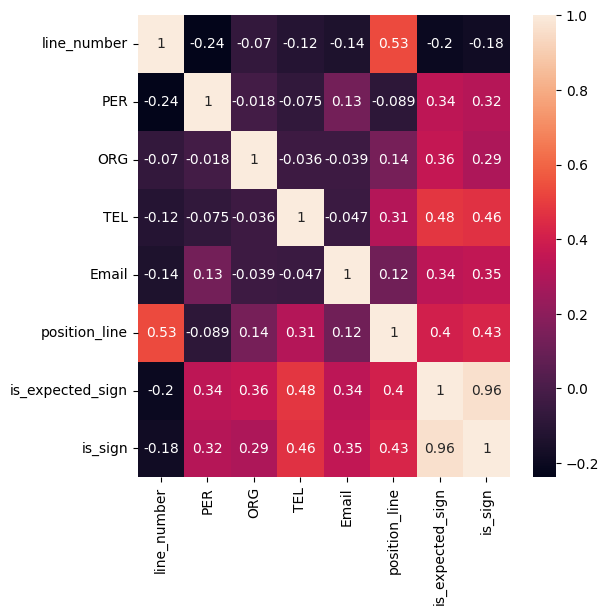

In [16]:
# heatmap for correlation
ax = sns.heatmap(df.corr(), annot=True, annot_kws={'size': 10})
figure = plt.gcf()  # get current figure
figure.set_size_inches(6, 6)



In [17]:
df.drop(['is_sign'],axis=1,inplace=True)

In [18]:
# scale all features by using MinMaxScaler for all features
# Select the columns to be scaled
cols_to_scale = ['PER', 'ORG', 'TEL', 'Email', 'position_line', 'is_expected_sign']

# Initialize the scaler
scaler = MinMaxScaler()
scaler.fit(df[cols_to_scale])
df[cols_to_scale] = scaler.transform(df[cols_to_scale])

df

line_number                                               line  PER  ORG  \
0              0                               Here is our forecast  0.0  0.0   
1              1                                             (NAME)  1.0  0.0   
2              2                                            (EMAIL)  0.0  0.0   
3              3                                            (PHONE)  0.0  0.0   
4              0  Traveling to have a business meeting takes the...  0.0  0.0   
..           ...                                                ...  ...  ...   
408           12                                         Thank you!  0.0  0.0   
409           13                                           Regards,  0.0  0.0   
410           14                                             (NAME)  1.0  0.0   
411           15                                              (ORG)  0.0  1.0   
412           16                                            (PHONE)  0.0  0.0   

     TEL  Email  position_line  is_expected_sign  
0    0.0    0.0       0.242718               0.0  
1    0.0    0.0       0.495146               1.0  
2    0.0    1.0       0.747573               1.0  
3    1.0    0.0       1.000000               1.0  
4    0.0    0.0       0.032362               0.0  
..   ...    ...            ...               ...  
408  0.0    0.0       0.762421               0.0  
409  0.0    0.0       0.821816               0.0  
410  0.0    0.0       0.881211               1.0  
411  0.0    0.0       0.940605               1.0  
412  1.0    0.0       1.000000               1.0  

[413 rows x 8 columns]

In [19]:
x = df[['is_expected_sign', 'TEL', 'position_line', 'Email', 'PER', 'ORG']].to_numpy()
x = np.expand_dims(x, axis=0)
x.shape

(1, 413, 6)

In [20]:
y = np.array(ann)
y = np.expand_dims(y, axis=0)
y.shape

(1, 413)

## Model Building

In [23]:
model = keras.Sequential()

model.add(keras.layers.Bidirectional(layer=keras.layers.LSTM(units=32,return_sequences=True, dropout = 0.05)))
#model.add(keras.layers.Bidirectional(layer=keras.layers.LSTM(3, return_sequences=True)))
model.add(keras.layers.Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam()
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=[keras.metrics.Precision(name="precision"),
                                                 keras.metrics.Recall(name="recall")])
model.build(x.shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (1, 413, 64)             9984      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (1, 413, 1)               65        
                                                                 
Total params: 10,049
Trainable params: 10,049
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(x,y,epochs=250, verbose=1)


Epoch 1/250
1/1 [==============================] - 5s 5s/step - loss: 0.6722 - precision: 0.2571 - recall: 0.1475
Epoch 2/250
1/1 [==============================] - 0s 110ms/step - loss: 0.6596 - precision: 0.2500 - recall: 0.0656
Epoch 3/250
1/1 [==============================] - 0s 116ms/step - loss: 0.6464 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/250
1/1 [==============================] - 0s 113ms/step - loss: 0.6324 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/250
1/1 [==============================] - 0s 110ms/step - loss: 0.6199 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/250
1/1 [==============================] - 0s 110ms/step - loss: 0.6064 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/250
1/1 [==============================] - 0s 114ms/step - loss: 0.5927 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8/250
1/1 [==============================] - 0s 114ms/step - loss: 0.5808 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 9/250
1/1 [==

1/1 [==============================] - 0s 119ms/step - loss: 0.1710 - precision: 0.8837 - recall: 0.6230
Epoch 136/250
1/1 [==============================] - 0s 110ms/step - loss: 0.1663 - precision: 0.8718 - recall: 0.5574
Epoch 137/250
1/1 [==============================] - 0s 114ms/step - loss: 0.1679 - precision: 0.8788 - recall: 0.4754
Epoch 138/250
1/1 [==============================] - 0s 106ms/step - loss: 0.1670 - precision: 0.9020 - recall: 0.7541
Epoch 139/250
1/1 [==============================] - 0s 143ms/step - loss: 0.1611 - precision: 0.9167 - recall: 0.7213
Epoch 140/250
1/1 [==============================] - 0s 112ms/step - loss: 0.1588 - precision: 0.9000 - recall: 0.5902
Epoch 141/250
1/1 [==============================] - 0s 115ms/step - loss: 0.1562 - precision: 0.9459 - recall: 0.5738
Epoch 142/250
1/1 [==============================] - 0s 113ms/step - loss: 0.1598 - precision: 0.9111 - recall: 0.6721
Epoch 143/250
1/1 [==============================] - 0s 114ms/

Epoch 204/250
1/1 [==============================] - 0s 111ms/step - loss: 0.0909 - precision: 0.9672 - recall: 0.9672
Epoch 205/250
1/1 [==============================] - 0s 108ms/step - loss: 0.0889 - precision: 0.9516 - recall: 0.9672
Epoch 206/250
1/1 [==============================] - 0s 109ms/step - loss: 0.0859 - precision: 0.9677 - recall: 0.9836
Epoch 207/250
1/1 [==============================] - 0s 116ms/step - loss: 0.0807 - precision: 0.9836 - recall: 0.9836
Epoch 208/250
1/1 [==============================] - 0s 108ms/step - loss: 0.0813 - precision: 1.0000 - recall: 0.9508
Epoch 209/250
1/1 [==============================] - 0s 109ms/step - loss: 0.0867 - precision: 0.9649 - recall: 0.9016
Epoch 210/250
1/1 [==============================] - 0s 109ms/step - loss: 0.0787 - precision: 0.9667 - recall: 0.9508
Epoch 211/250
1/1 [==============================] - 0s 126ms/step - loss: 0.0861 - precision: 0.9636 - recall: 0.8689
Epoch 212/250
1/1 [=============================

In [25]:
y_predict = model.predict(x)>0.5
y_predict = np.multiply(y_predict, 1)
y_predict = np.reshape(y_predict, (1,np.product(y_predict.shape)))[0]
print(y_predict)

1/1 [==============================] - 1s 973ms/step
[0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0
 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1]


In [26]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(ann, y_predict, average=None)

# Calculate weighted F1 score
weighted_f1_score = f1_score.mean()

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)
print('Weighted F1 score:', weighted_f1_score)


Precision: [1.         0.96825397]
Recall: [0.99431818 1.        ]
F1 score: [0.997151   0.98387097]
Weighted F1 score: 0.9905109824464663


In [27]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#calculating precision and reall
precision = precision_score(ann, y_predict)
recall = recall_score(ann, y_predict)
 
print('Precision: ',precision)
print('Recall: ',recall)

Precision:  0.9682539682539683
Recall:  1.0
